# Melanoma Detection - Image Preprocessing Pipeline

This notebook implements a comprehensive preprocessing pipeline for dermoscopic images, including:
1. Hair removal (DullRazor algorithm)
2. Artifact removal
3. Contrast enhancement (CLAHE)
4. Image normalization
5. Data augmentation

The pipeline is designed to be modular and reusable.

In [116]:
# === Imports ===
import os
import numpy as np
import pandas as pd
import cv2
import random
from pathlib import Path
from typing import Tuple, List, Optional
from dataclasses import dataclass
import albumentations as A
from tqdm import tqdm
import matplotlib.pyplot as plt
!jupyter nbexten    sion enable --py widgetsnbextension

Failed to canonicalize script path


In [117]:
# === Configuration ===
@dataclass
class PreprocessingConfig:
    """Configuration for the preprocessing pipeline"""

    target_size: Tuple[int, int] = (
        224,
        224,
    )
    clahe_clip_limit: float = 2.0
    clahe_grid_size: Tuple[int, int] = (8, 8)
    hair_removal_threshold: int = 10
    augmentation_probability: float = 0.5
    random_seed: int = 42


In [118]:
# === Image Preprocessing ===
class ImagePreprocessor:
    """Handles all image preprocessing steps for dermoscopic images"""

    def __init__(self, config: PreprocessingConfig):
        self.config = config
        self._setup_augmentation()

    def _setup_augmentation(self):
        """Setup augmentation pipeline using albumentations"""
        self.augmentation = A.Compose(
            [
                A.RandomRotate90(p=self.config.augmentation_probability),
                A.HorizontalFlip(p=self.config.augmentation_probability),
                A.ShiftScaleRotate(
                    shift_limit=0.0625,
                    scale_limit=0.1,
                    rotate_limit=45,
                    p=self.config.augmentation_probability,
                ),
                A.OneOf(
                    [
                        A.ElasticTransform(
                            alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5
                        ),
                        A.GridDistortion(p=0.5),
                        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.5),
                    ],
                    p=0.3,
                ),
                A.OneOf(
                    [
                        A.GaussNoise(p=0.5),
                        A.RandomBrightnessContrast(p=0.5),
                        A.RandomGamma(p=0.5),
                    ],
                    p=0.3,
                ),
            ]
        )

    def remove_hair(self, image: np.ndarray) -> np.ndarray:
        """Remove hair from dermoscopic images using DullRazor algorithm"""
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Apply blackhat morphology for hair detection
        kernel_sizes = [
            (7, 11),
            (11, 7),
            (9, 9),
        ]  # Vertical, horizontal, and square kernels
        mask = np.zeros_like(gray)

        for kernel_size in kernel_sizes:
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
            blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
            bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
            _, thresh = cv2.threshold(
                bhg, self.config.hair_removal_threshold, 255, cv2.THRESH_BINARY
            )
            mask = cv2.bitwise_or(mask, thresh)

        # Inpaint the hair regions
        result = cv2.inpaint(image, mask, 6, cv2.INPAINT_TELEA)
        return result

    def enhance_contrast(self, image: np.ndarray) -> np.ndarray:
        """Apply CLAHE for contrast enhancement"""
        # Convert to LAB color space
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        # Apply CLAHE to L channel
        clahe = cv2.createCLAHE(
            clipLimit=self.config.clahe_clip_limit,
            tileGridSize=self.config.clahe_grid_size,
        )
        cl = clahe.apply(l)

        # Merge channels and convert back to RGB
        enhanced = cv2.merge((cl, a, b))
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)
        return enhanced

    def normalize_image(self, image: np.ndarray) -> np.ndarray:
        """Normalize image to [0, 1] range"""
        return image.astype(np.float32) / 255.0

    def resize_image(self, image: np.ndarray) -> np.ndarray:
        """Resize image to target size"""
        return cv2.resize(image, self.config.target_size, interpolation=cv2.INTER_AREA)

    def apply_augmentation(self, image: np.ndarray) -> np.ndarray:
        """Apply data augmentation"""
        augmented = self.augmentation(image=image)
        return augmented["image"]

    def process_image(
        self, image: np.ndarray, apply_augmentation: bool = False
    ) -> np.ndarray:
        """Apply the complete preprocessing pipeline"""
        # Convert to RGB if image is in BGR format
        if image.shape[-1] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply preprocessing steps
        image = self.remove_hair(image)
        image = self.enhance_contrast(image)
        image = self.resize_image(image)

        if apply_augmentation:
            image = self.apply_augmentation(image)

        # Normalize as the final step
        image = self.normalize_image(image)
        return image


In [119]:
class DatasetPreprocessor:
    """Handles preprocessing of the entire dataset"""

    def __init__(self, config: PreprocessingConfig):
        self.config = config
        self.image_processor = ImagePreprocessor(config)

    def process_dataset(
        self,
        input_dir: str,
        output_dir: str,
        labels_df: pd.DataFrame,
        augment_ratio: float = 0.5,
    ) -> None:
        """Process the entire dataset and save preprocessed images"""
        # Create output directories
        processed_dir = Path(output_dir) / "processed"
        augmented_dir = Path(output_dir) / "augmented"

        for dir_path in [processed_dir, augmented_dir]:
            (dir_path / "melanoma").mkdir(parents=True, exist_ok=True)
            (dir_path / "non_melanoma").mkdir(parents=True, exist_ok=True)

        # Process each image
        for idx, row in tqdm(
            labels_df.iterrows(), total=len(labels_df), desc="Processing images"
        ):
            image_name = row["image"]
            is_melanoma = row["MEL"] == 1.0

            # Read image
            image_path = Path(input_dir) / f"{image_name}.jpg"
            if not image_path.exists():
                print(f"Warning: Image {image_path} not found. Skipping.")
                continue

            image = cv2.imread(str(image_path))
            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue

            # Process image
            processed_image = self.image_processor.process_image(image, apply_augmentation=False) # Ensure base processed image is not augmented

            # Save processed image
            category = "melanoma" if is_melanoma else "non_melanoma"
            output_path = processed_dir / category / f"{image_name}.jpg"
            # Convert to BGR for saving with cv2.imwrite
            cv2.imwrite(str(output_path), cv2.cvtColor((processed_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))


            # Create augmented versions
            if is_melanoma:
                for i in range(3):  # Create 3 augmented versions for melanoma
                    augmented_image = self.image_processor.process_image(
                        image, apply_augmentation=True
                    )
                    aug_output_path = (
                        augmented_dir / category / f"{image_name}_aug_{i+1}.jpg"
                    )
                    cv2.imwrite(
                        str(aug_output_path), cv2.cvtColor((augmented_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
                    )
            elif random.random() < augment_ratio: # For non-melanoma, augment based on ratio
                augmented_image = self.image_processor.process_image(
                    image, apply_augmentation=True
                )
                aug_output_path = augmented_dir / category / f"{image_name}_aug.jpg"
                cv2.imwrite(
                    str(aug_output_path), cv2.cvtColor((augmented_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
                )


In [120]:
# === Path Setup ===
base_path = Path("../../../")
image_folder = base_path / "ISIC_2019_Training_Input" / "ISIC_2019_Training_Input"
labels_path = base_path / "ISIC_2019_Training_GroundTruth.csv"
output_dir = base_path / "working"

# Load labels
df = pd.read_csv(labels_path)
print("\nTraining labels preview:")
print(df.head())

# Create simplified labels (focusing on melanoma classification)
df_simplified = df[["image", "MEL"]]
print("\nClass distribution:")
print(df_simplified["MEL"].value_counts(normalize=True) * 100)


Training labels preview:
          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0

Class distribution:
MEL
0.0    82.148356
1.0    17.851644
Name: proportion, dtype: float64


In [121]:
# Initialize and run preprocessing pipeline
config = PreprocessingConfig()
preprocessor = DatasetPreprocessor(config)

# Process the dataset
preprocessor.process_dataset(
    input_dir=str(image_folder),
    output_dir=str(output_dir),
    labels_df=df_simplified,
    augment_ratio=0.5  # Augment 50% of the images
)

c:\Users\Priya\Downloads\kaggle\melanoma-project\.venv\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\Priya\AppData\Local\Temp\ipykernel_12060\1176083158.py:23: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(
C:\Users\Priya\AppData\Local\Temp\ipykernel_12060\1176083158.py:27: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.5),
Processing images: 100%|██████████| 25331/25331 [2:04:35<00:00,  3.39it/s]  


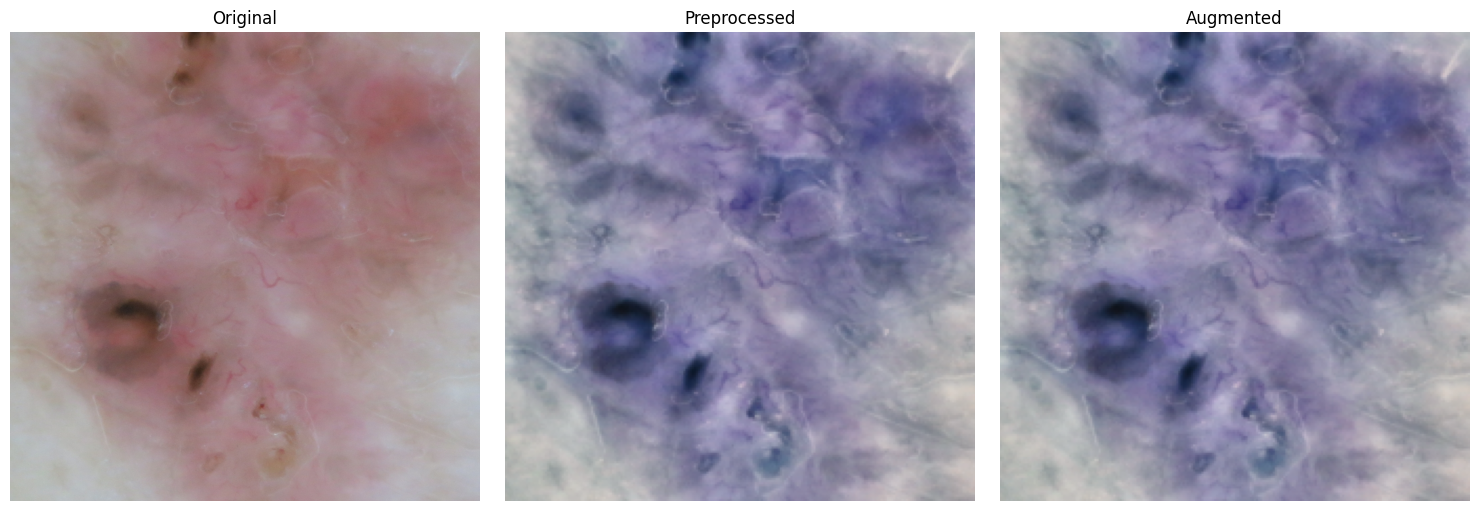

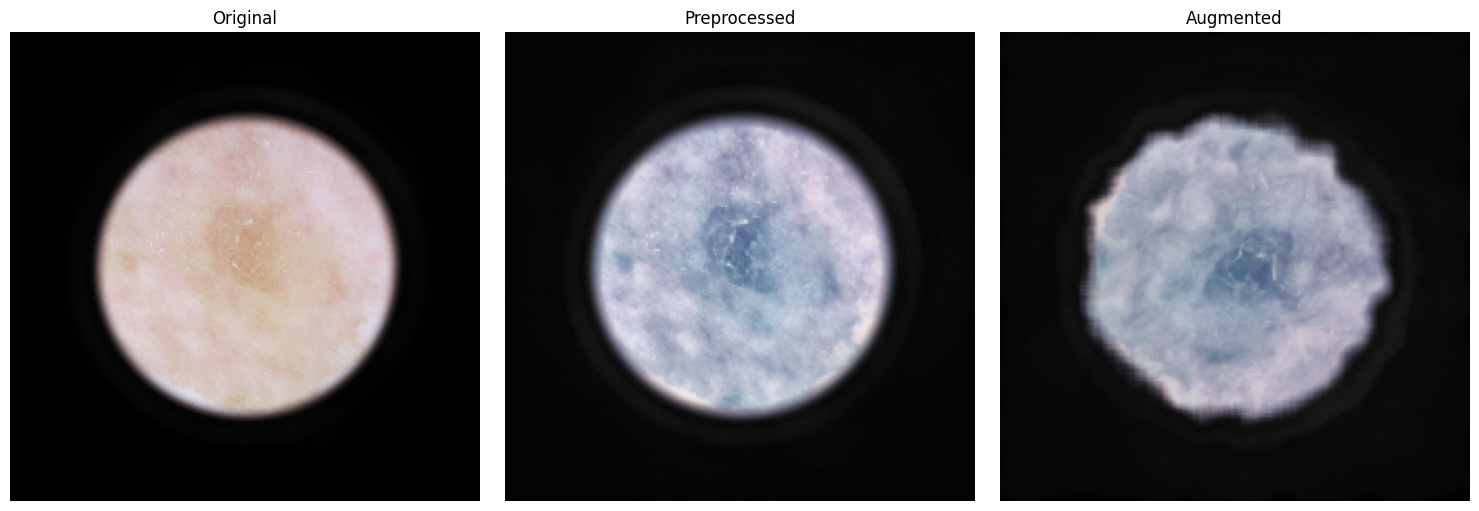

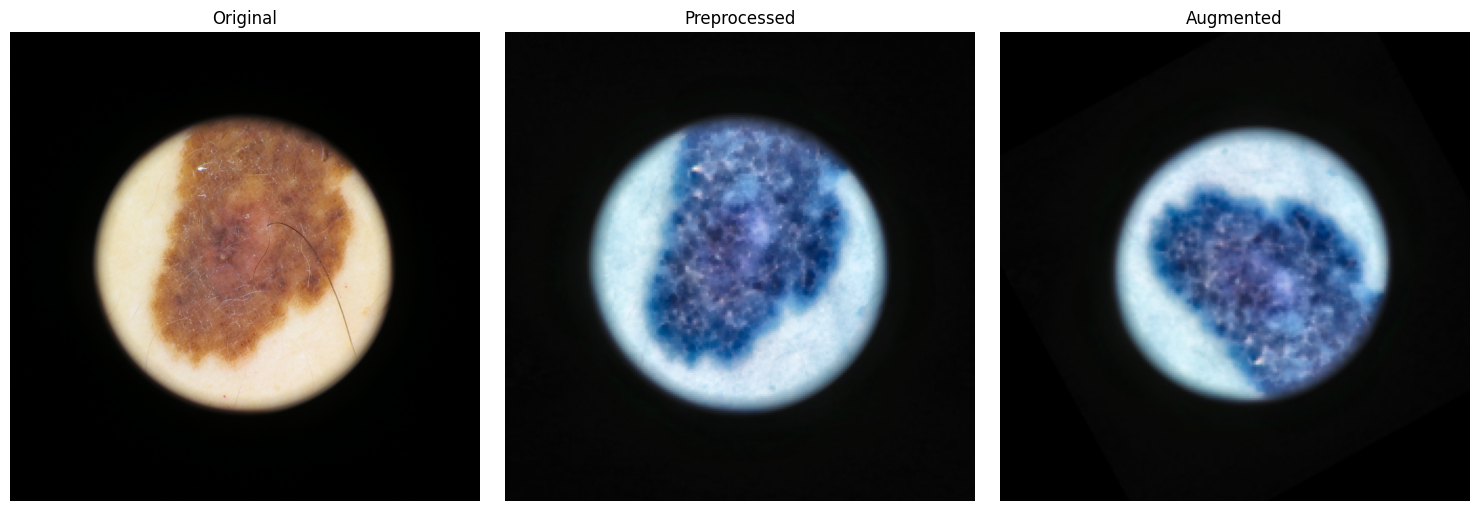

In [124]:
# Visualize some preprocessed images
def visualize_preprocessing(image_path: str):
    """Visualize original and preprocessed images"""
    # Read original image
    original = cv2.imread(image_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Process image
    processed = preprocessor.image_processor.process_image(original)
    
    # Create augmented version
    augmented = preprocessor.image_processor.process_image(original, apply_augmentation=True)
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    axes[1].imshow(processed)
    axes[1].set_title('Preprocessed')
    axes[1].axis('off')
    
    axes[2].imshow(augmented)
    axes[2].set_title('Augmented')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize a few random images
for _ in range(3):
    random_image = random.choice(os.listdir(image_folder))
    image_path = os.path.join(image_folder, random_image)
    visualize_preprocessing(image_path)